# Quick Start  

Running a multi-objective optimization requires four key components: 
- A Problem class (**HEA_problem**) defines the relationship between input variables (alloy composition) and the real objectives (NRR catalytic performance).
- A surrogate model (**GPR**) that is built to approximate the underlying performance landscape.
- A Pareto optimization algorithm (**ParetoDiscovery**) that is employed to navigate the trade-offs.
- The **MOBO** function integrates these modules to execute the full optimization.


In [2]:
from heaict.cats.problem import HEA_problem
from heaict.ml.GPR_gpflow import GPR
from heaict.mobo.partor_discover import ParetoDiscovery
from heaict.mobo.mobo import MOBO

Define the problem by specifying the elements and surface parameters.   
In this demonstration, we attempt to replicate literature results by constructing a 150×150×3 slab model of the NiPdCuMnRu high-entropy alloy.

**Note:**  
This task was executed on a system with an Intel i7-10700 CPU and an NVIDIA RTX 3090 GPU, taking approximately 10 hours. For a quicker trial, parameters such as the surface size and the number of iterations can be reduced.  
Steps for ML adsorption energy prediction and usage of extended surface are pre-defined in the problem class, which must be customized for other studies.  

In [3]:
p = HEA_problem(size=150, archetype=f'Data/Archetype_slab/n3/', model=f'Data/Model_dict/Model_25107_dict.pt', eles=['Ni', 'Pd', 'Cu', 'Mn', 'Ru'])

Pass the defined problem to the surrogate model.

In [4]:
sm = GPR(real_problem=p, gp_kernel=0.5)

Set the hyperparameters for the multi-objective optimization algorithm.

In [6]:
al = ParetoDiscovery(n_gen=6, 
                     pop_size=30, 
                     n_grid_sample=1000,
                     perturb_method='gaussian', 
                     delta_p=0.1,
                     delta_s=0.3,
                     cell_num=100,
                     sparse_approx=False)

Pass the algorithm and the surrogate model into the MOBO function and execute the multi-objective optimization.

In [7]:
mobo = MOBO(surrogate_model=sm, algorithm=al)

In [8]:
X, Y = mobo.optimize(n_init=30, n_iter=6, update_final=True, return_real=True)

------ Start optimization - [2025-12-21 22:31:56]
Generate 30 initial samples
------ Iteration 1 - [2025-12-21 22:31:57]
Evaluate 30 data points from real problem - [2025-12-21 22:31:57]
hea Ni0.15-Pd0.28-Cu0.1-Mn0.12-Ru0.35 - [2025-12-21 22:32:01]
hea Ni0.31-Pd0.08-Cu0.18-Mn0.29-Ru0.14 - [2025-12-21 22:36:56]
hea Ni0.29-Pd0.07-Cu0.31-Mn0.21-Ru0.12 - [2025-12-21 22:41:49]
hea Ni0.32-Pd0.13-Cu0.2-Mn0.28-Ru0.07 - [2025-12-21 22:46:43]
hea Ni0.08-Pd0.25-Cu0.29-Mn0.08-Ru0.3 - [2025-12-21 22:51:37]
hea Ni0.26-Pd0.13-Cu0.12-Mn0.33-Ru0.16 - [2025-12-21 22:56:30]
hea Ni0.22-Pd0.21-Cu0.12-Mn0.21-Ru0.24 - [2025-12-21 23:01:23]
hea Ni0.18-Pd0.28-Cu0.25-Mn0.1-Ru0.19 - [2025-12-21 23:06:16]
hea Ni0.2-Pd0.33-Cu0.28-Mn0.14-Ru0.05 - [2025-12-21 23:11:08]
hea Ni0.21-Pd0.34-Cu0.23-Mn0.16-Ru0.06 - [2025-12-21 23:16:01]
hea Ni0.28-Pd0.15-Cu0.27-Mn0.24-Ru0.06 - [2025-12-21 23:20:54]
hea Ni0.32-Pd0.26-Cu0.19-Mn0.17-Ru0.06 - [2025-12-21 23:25:47]
hea Ni0.07-Pd0.25-Cu0.22-Mn0.31-Ru0.15 - [2025-12-21 23:30:40]

Finally, we present the results.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from heaict.mobo.utility import find_pareto_front
from heaict.mobo.plot import plot_performance_metric
from heaict.cats.utility import round_preserve_sum

First, Let us check the hypervolume trends. It is clear that the optimation get converage after 4 iterations (with 70 evaluated samples).

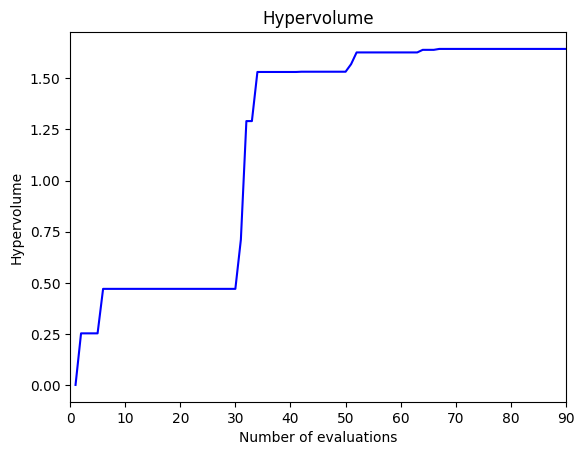

In [14]:
plot_performance_metric(Y)

This next figure shows the distribution of all evaluated samples and the Pareto front in the objective space.

In [56]:
Y_pf, pf_indices = find_pareto_front(Y)

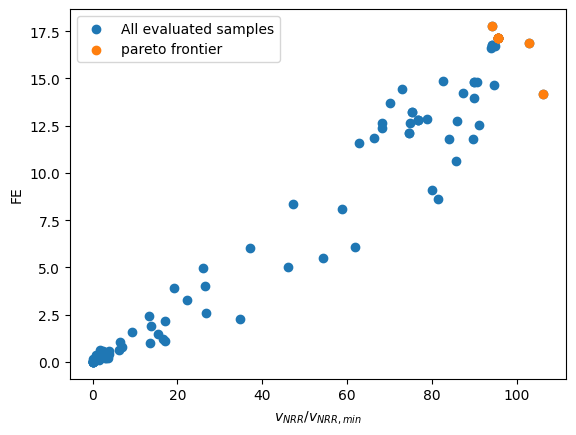

In [16]:
min_vNRR = 0.00011868571608905117
plt.scatter(np.exp(-1*Y[:, 0]) / min_vNRR, -100*Y[:, 1], label='All evaluated samples')
plt.scatter(np.exp(-1*Y_pf[:, 0]) / min_vNRR, -100*Y_pf[:, 1], label='pareto frontier')
plt.ylabel('FE')
plt.xlabel('$v_{NRR}/v_{NRR,min}$')
plt.legend()

We now transform the Pareto set into a more interpretable representation. Three points align with the literature, while one point performs slightly worse. In practice, consistency can be ensured by fixing the problem definition (parameters inside problem) and the random seed for the entire multi-objective optimization process (fix numpy related seed befor starting the optimation). Alternatively, the reliability of the results can be improved through multiple optimization runs, increasing the initial sample size, or allocating more samples to the optimization algorithm itself.

In [57]:
Y_pf[:, 1] = Y_pf[:, 1] * -100
Y_pf[:, 0] = np.exp(-1*Y_pf[:, 0]) / min_vNRR
Y_pf=np.unique(np.round(Y_pf, 2), axis=0)

X_pf = X[pf_indices]
X_pf = np.column_stack((X_pf, 1-np.sum(X_pf, axis=1).reshape(-1, 1)))
X_pfr = []
for x in X_pf:
    X_pfr.append(round_preserve_sum(x))
X_pf=np.array(X_pfr)
X_pf=np.unique(X_pf, axis=0)

In [59]:
X_pf

array([[0.31, 0.11, 0.08, 0.35, 0.15],
       [0.32, 0.13, 0.05, 0.35, 0.15],
       [0.34, 0.11, 0.05, 0.35, 0.15],
       [0.35, 0.1 , 0.05, 0.35, 0.15]])

In [58]:
Y_pf

array([[ 94.27,  17.78],
       [ 95.56,  17.15],
       [103.  ,  16.86],
       [106.32,  14.2 ]])